In [1]:
import os.path as osp
import pandas as pd

import os

In [3]:
data_dir = osp.join(os.path.abspath(''), "mijnomgeving_data/")

In [4]:
_full_df = []
for sensor_date in os.listdir(data_dir):
    _full_df += [pd.read_csv(osp.join(data_dir, sensor_date), parse_dates=["datetime", "timestamp"])]
    
full_df = pd.concat(_full_df)

In [5]:
processed_df = full_df.drop(['app_id', 'dev_id', 'altitude', 'course', 'boardTemperature', "FixAge", 
                             'time', 'timestamp', 'lastResetCause', 'imei', "SatInFix", "TimeActive", "speed", "batteryVoltage"], axis=1)

In [6]:
df = processed_df

In [7]:
import datetime

time_diff = datetime.datetime.now() - max(df['datetime'])
df["datetime"] = df["datetime"] + time_diff
min(df["datetime"]), max(df["datetime"])

(Timestamp('2019-12-15 11:42:57.812973'),
 Timestamp('2020-11-29 11:42:52.088973'))

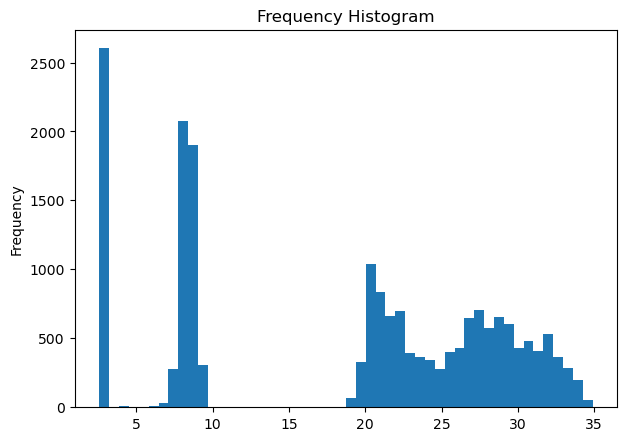

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = df['pH']
plt.hist(x, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');


In [9]:
df = df[df["datetime"] >= datetime.datetime.now()-datetime.timedelta(days=14)]

In [10]:
anomalies = df[(df["waterEC"] >= 1000) | (df["pH"] <= 8.2) | (df["pH"] >= 9.1)]

In [11]:
df = anomalies.sort_values(by="datetime")

In [12]:
sensors = [x for x in pd.unique(df['name']) if type(x) == str]
sensors = [x for x in sensors if "Error" not in x]
sensors

['EC 305',
 'EC 230',
 'EC 221',
 'EC 301',
 'EC 318',
 'EC 309',
 'EC 306',
 'EC 308',
 'EC 303',
 'EC 311',
 'EC 307',
 'EC 205',
 'EC 302',
 'EC 314',
 'EC 320',
 'EC 313',
 'EC 244',
 'EC 209',
 'EC 321',
 'EC 326',
 'EC 330',
 'EC 315',
 'EC 222',
 'EC 201']

In [21]:
df

,datetime,Lat,Lon,waterEC,waterTemperature,pH,name
1,2020-11-15 11:43:30.769973,52.416621,5.226547,1797.0,18.97,NaN,EC 305
4,2020-11-15 11:43:58.078973,52.391560,4.936256,4540.0,18.00,NaN,EC 230
6,2020-11-15 11:45:46.141973,52.392154,4.937345,5500.0,19.85,NaN,EC 221
11,2020-11-15 11:47:59.357973,52.301191,5.360527,1753.0,17.65,NaN,EC 301
15,2020-11-15 11:50:46.525973,52.523021,5.590302,2561.0,17.30,NaN,EC 318
...,...,...,...,...,...,...,...
3701,2020-11-29 11:39:07.748973,52.541005,5.588715,2969.0,17.91,NaN,EC 302
3703,2020-11-29 11:39:37.816973,52.425742,5.420831,1504.0,18.35,NaN,EC 314
3705,2020-11-29 11:41:24.938973,52.425718,5.420774,1498.0,18.27,NaN,EC 314
3708,2020-11-29 11:42:08.035973,52.578960,5.756805,2489.0,17.56,NaN,EC 313


In [34]:
from random import randint, choice
provinces = ['Drenthe',
'Flevoland',
'Friesland (Fryslân)',
'Gelderland',
'Groningen',
'Limburg',
"Noord-Brabant — North Brabant",
'Noord-Holland — North Holland',
'Overijssel',
'Utrecht',
'Zeeland — Zealand',
'Zuid-Holland — South Holland',
]


data = {
    "data": []

}

for sens in sensors:
    sensor_data = df[df["name"] == sens].resample("60min", on='datetime').first()
    data["data"].append(
    {
        "id": f"{sensor_data['name'].values[0]}_{sensor_data['Lon'].values[0]}_{sensor_data['Lat'].values[0]}", 
        "creatorId": sens,
        "creatorType": "sensor",
        "anomalyType": "water",
        "created": datetime.datetime.now() - datetime.timedelta(days=randint(0, 13)),
        "location": {
        "coordinates": [sensor_data["Lat"].values[0], sensor_data["Lon"].values[0]],
        "province": choice(provinces), 
        "components": {
            "EC": {
                "max": 1000,
                "alert": "true",
                "unit": "us/cm",
                "data": [{'timestamp': k.strftime('%Y-%m-%d %H-%M-', 'value': v} for k, v in sensor_data[['datetime', 'waterEC']].values]
            }
        }
        }
    }
        
    )

In [35]:
data

{'data': [{'id': 'EC 305_5.2265473_52.4166211',
   'creatorId': 'EC 305',
   'creatorType': 'sensor',
   'anomalyType': 'water',
   'created': datetime.datetime(2020, 11, 19, 12, 25, 43, 852974),
   'location': {'coordinates': [52.4166211, 5.2265473],
    'province': 'Zuid-Holland — South Holland',
    'components': {'EC': {'max': 1000,
      'alert': 'true',
      'unit': 'us/cm',
      'data': [{'timestamp': Timestamp('2020-11-15 11:43:30.769973'),
        'value': 1797.0},
       {'timestamp': Timestamp('2020-11-15 12:13:18.367973'), 'value': 1781.0},
       {'timestamp': Timestamp('2020-11-15 13:13:18.880973'), 'value': 1795.0},
       {'timestamp': Timestamp('2020-11-15 14:13:31.707973'), 'value': 1815.0},
       {'timestamp': Timestamp('2020-11-15 15:13:10.293973'), 'value': 1822.0},
       {'timestamp': Timestamp('2020-11-15 16:13:11.973973'), 'value': 1812.0},
       {'timestamp': Timestamp('2020-11-15 17:13:02.561973'), 'value': 1784.0},
       {'timestamp': Timestamp('2020-11

In [124]:
df['name']

0       EC 319
1       EC 313
2       EC 314
3       EC 226
4       EC 312
         ...  
3949    EC 321
3950    EC 308
3951    EC 320
3952    EC 320
3953       NaN
Name: name, Length: 47511, dtype: object